In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Flatten
from keras.initializers import Constant
from textblob import TextBlob
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

In [68]:
df = pd.read_csv('DatingAppReviewsDataset.csv')
df.head()

,Unnamed: 0,Name,Review,Rating,#ThumbsUp,Date&Time,App
0,0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder
1,1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder
2,2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder
3,3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder
4,4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder


In [69]:
df.shape

(681994, 7)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681994 entries, 0 to 681993
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  681994 non-null  int64 
 1   Name        681987 non-null  object
 2   Review      680609 non-null  object
 3   Rating      681994 non-null  int64 
 4   #ThumbsUp   681994 non-null  int64 
 5   Date&Time   681994 non-null  object
 6   App         681994 non-null  object
dtypes: int64(3), object(4)
memory usage: 36.4+ MB


In [71]:
df.isnull().sum()

Unnamed: 0       0
Name             7
Review        1385
Rating           0
#ThumbsUp        0
Date&Time        0
App              0
dtype: int64

In [72]:
df.dropna(subset = ['Name', 'Review'], inplace = True)

In [73]:
df.apply(pd.isnull).sum()

Unnamed: 0    0
Name          0
Review        0
Rating        0
#ThumbsUp     0
Date&Time     0
App           0
dtype: int64

In [74]:
df.shape

(680602, 7)

In [75]:
data = df[['Review', 'Rating']]

In [76]:
data.head()

,Review,Rating
0,On this app i cant find a partner,5
1,Tinder would be so much better if we could spe...,3
2,Still doesn't correctly notify matches or mess...,1
3,"Got banned because I updated my bio to say ""I ...",2
4,Love it!,5


In [77]:
data['Rating'].value_counts()

Rating
1    251838
5    232732
4     86958
3     56850
2     52223
0         1
Name: count, dtype: int64

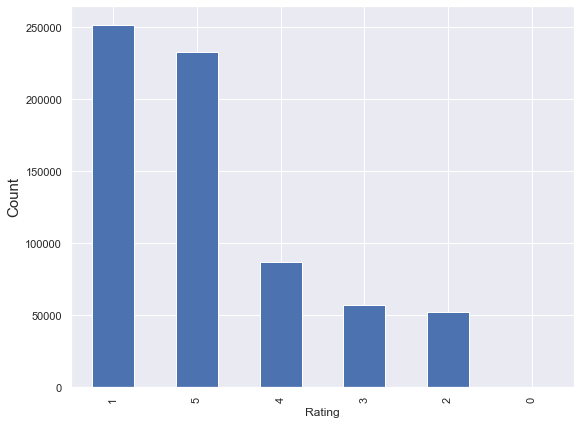

In [78]:
data['Rating'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.ylabel('Count', fontsize = 15)
plt.show()

In [79]:
df_1 = data[data['Rating'] == 1].sample(50000)
df_2 = data[data['Rating'] == 2].sample(50000)
df_3 = data[data['Rating'] == 3].sample(50000)
df_4 = data[data['Rating'] == 4].sample(50000)
df_5 = data[data['Rating'] == 5].sample(50000)

In [80]:
df_balanced = pd.concat([df_1, df_2, df_3, df_4, df_5])

In [81]:
df_balanced.head()

,Review,Rating
332089,Every time it is asking fb login.....,1
179429,if you're a woman expect to get solicited for ...,1
317946,Logged me out tells me error 40303 which I loo...,1
295882,"First day and can't even access my messages, ...",1
661446,horrible the app showed me exact opposite of m...,1


In [82]:
df_balanced.shape

(250000, 2)

In [83]:
df_balanced['Rating'].value_counts()

Rating
1    50000
2    50000
3    50000
4    50000
5    50000
Name: count, dtype: int64

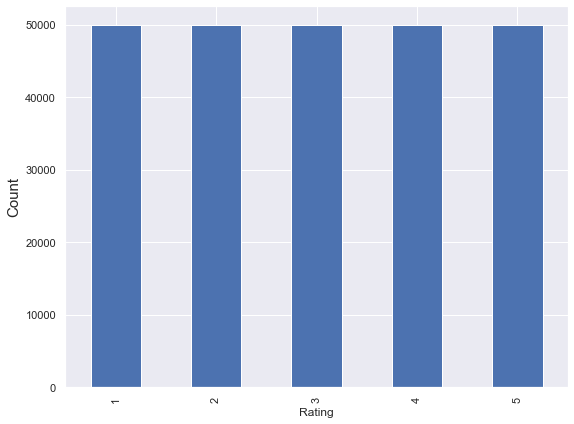

In [84]:
df_balanced['Rating'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.ylabel('Count', fontsize = 15)
plt.show()

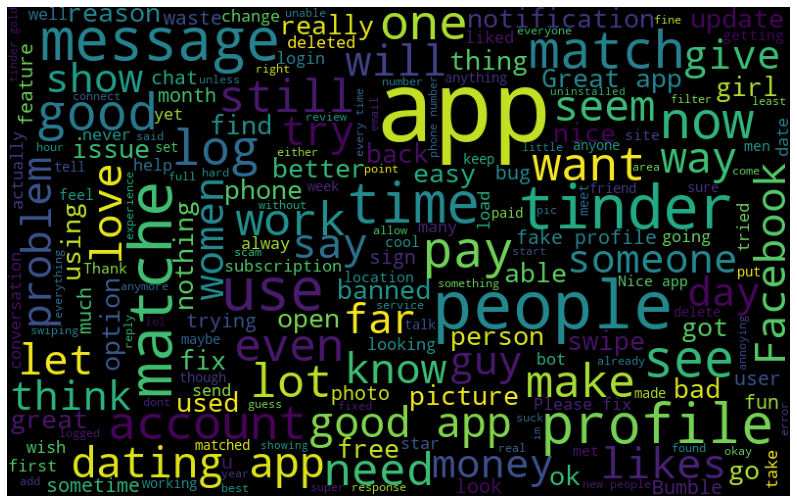

In [85]:
plt.figure(figsize = (15, 9))
all_sen = ' '.join([sentence for sentence in df_balanced['Review']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sen)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [86]:
def wordcloud_show(data, rating):
    plt.figure(figsize = (15, 9))
    s = ' '.join([sentence for sentence in data['Review'][data['Rating'] == rating]])
    word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(s)
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title(rating)
    plt.show()

In [87]:
r = df_balanced['Rating'].unique()

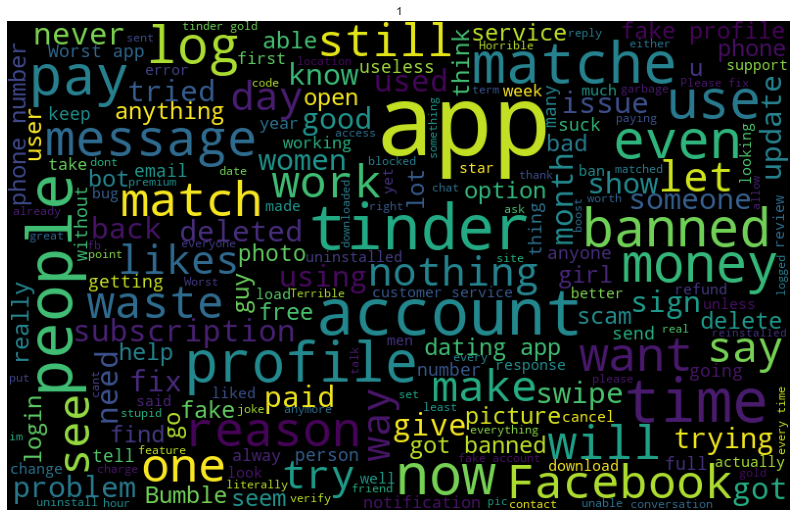

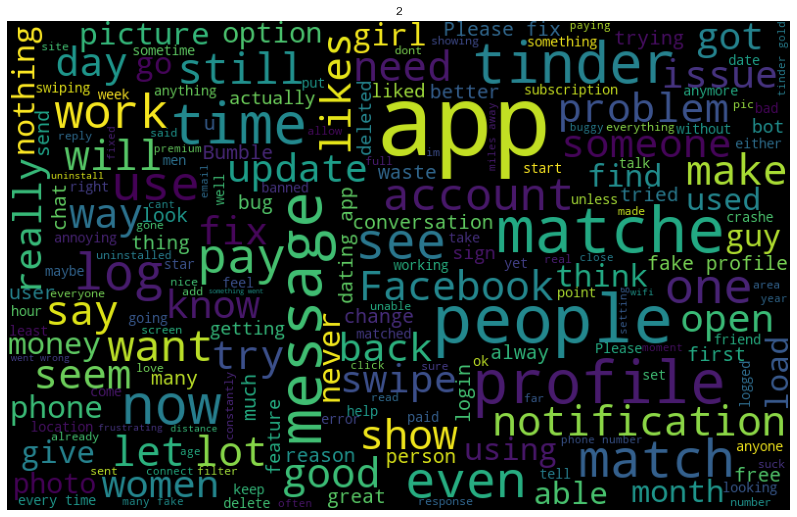

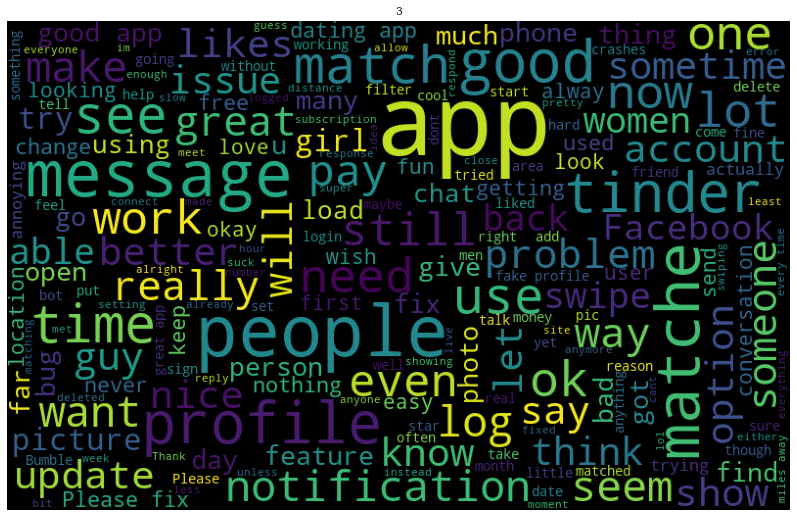

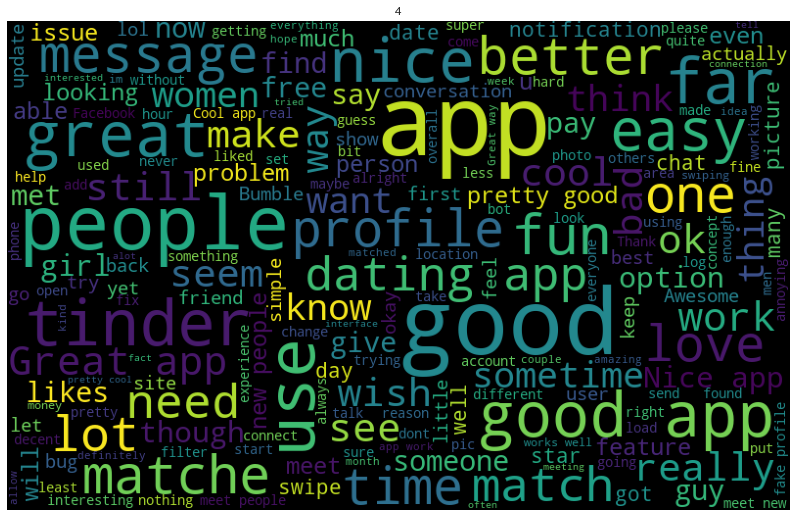

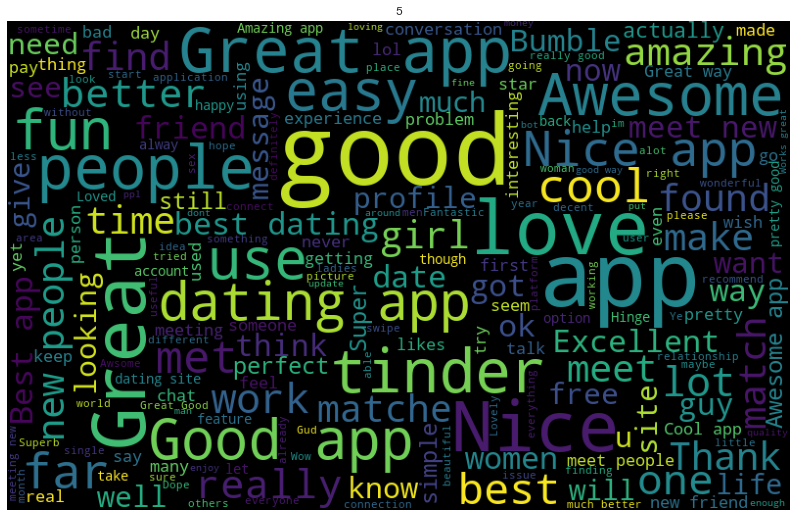

In [88]:
for i in r:
    wordcloud_show(df_balanced, i)

In [89]:
def text_blob(text):
    tb = TextBlob(text).sentiment[0]
    if tb > 0:
        return 1
    else:
        return 0

In [90]:
df_balanced['label'] = df_balanced['Review'].apply(text_blob)

In [91]:
df_balanced.sample(10)

,Review,Rating,label
196712,wooooo,5,0
138869,Account got banned for no reason at all,4,0
353224,This is one of the best dating app I have ever...,5,1
164753,Best,5,1
244444,hmm,4,0
182055,This app used to be good but never loads up an...,4,1
436350,Turn on gps Turn on gps Turn on gps Turn on gp...,2,0
275311,It's ok but not big on communications between ...,3,1
318038,Worst app,1,0
42979,Its a good app in general but ive had the app ...,2,1


In [92]:
df_balanced['label'].value_counts()

label
1    135989
0    114011
Name: count, dtype: int64

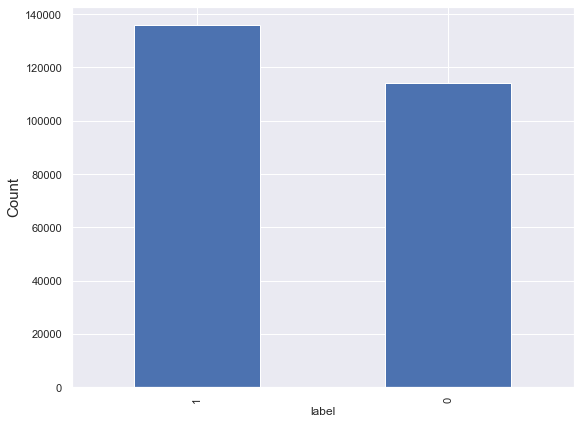

In [93]:
df_balanced['label'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.ylabel('Count', fontsize = 15)
plt.show()

In [94]:
df_balanced_z = df_balanced[df_balanced['label'] == 0]
df_balanced_o = df_balanced[df_balanced['label'] == 1].sample(df_balanced_z.shape[0])

In [95]:
df_balanced_f = pd.concat([df_balanced_z, df_balanced_o])

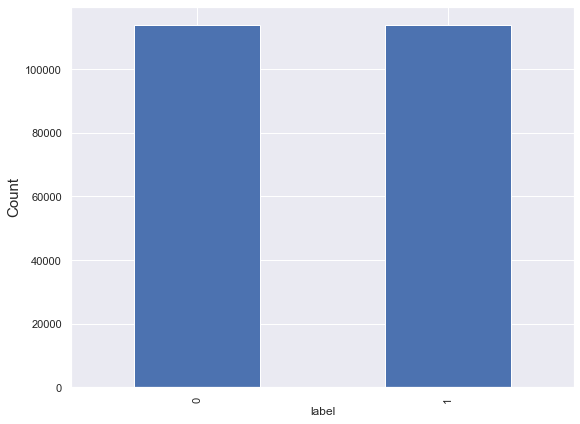

In [96]:
df_balanced_f['label'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.ylabel('Count', fontsize = 15)
plt.show()

In [97]:
df_balanced_f.shape

(228022, 3)

In [98]:
sw = stopwords.words('english')

In [99]:
lemmatizer = WordNetLemmatizer()

In [100]:
def review_preprocessing(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [101]:
df_balanced_f['pre_review'] = df_balanced_f['Review'].apply(review_preprocessing)

In [102]:
df_balanced_f.head()

,Review,Rating,label,pre_review
332089,Every time it is asking fb login.....,1,0,every time asking fb login
179429,if you're a woman expect to get solicited for ...,1,0,woman expect get solicited sex regular basis m...
317946,Logged me out tells me error 40303 which I loo...,1,0,logged tell error looked mean banned anything ...
295882,"First day and can't even access my messages, ...",1,0,first day even access message however still se...
661446,horrible the app showed me exact opposite of m...,1,0,horrible app showed exact opposite preference ...


In [103]:
tokenizer = Tokenizer()

In [104]:
tokenizer.fit_on_texts(df_balanced_f['pre_review'])
seq = tokenizer.texts_to_sequences(df_balanced_f['pre_review'])

In [105]:
maxlen = max([len(i) for i in seq])
maxlen

363

In [106]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [108]:
X = pad_seq
y = df_balanced_f['label']

In [109]:
vocab_size = len(tokenizer.word_index) + 1

In [110]:
vocab_size

40886

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True, stratify = y)

In [112]:
print('The size of training set is:', X_train.shape)
print('The size of test set is:', X_test.shape)

The size of training set is: (182417, 363)
The size of test set is: (45605, 363)


In [113]:
glove_file = open('glove.6B.100d.txt', encoding = 'utf-8')
embedding_matrix = dict()
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_matrix[word] = vector
glove_file.close()

In [114]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [115]:
model = Sequential()

In [116]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(5)))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [117]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [118]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [119]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [120]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1, callbacks = [early_stopping])

Epoch 1/100
5131/5131 ━━━━━━━━━━━━━━━━━━━━ 1055s 202ms/step - accuracy: 0.8223 - loss: 0.4127 - val_accuracy: 0.9207 - val_loss: 0.2193
Epoch 2/100
5131/5131 ━━━━━━━━━━━━━━━━━━━━ 1058s 206ms/step - accuracy: 0.9130 - loss: 0.2494 - val_accuracy: 0.9265 - val_loss: 0.2087
Epoch 3/100
5131/5131 ━━━━━━━━━━━━━━━━━━━━ 1011s 197ms/step - accuracy: 0.9224 - loss: 0.2231 - val_accuracy: 0.9253 - val_loss: 0.2128
Epoch 4/100
5131/5131 ━━━━━━━━━━━━━━━━━━━━ 993s 194ms/step - accuracy: 0.9277 - loss: 0.2090 - val_accuracy: 0.9232 - val_loss: 0.2195


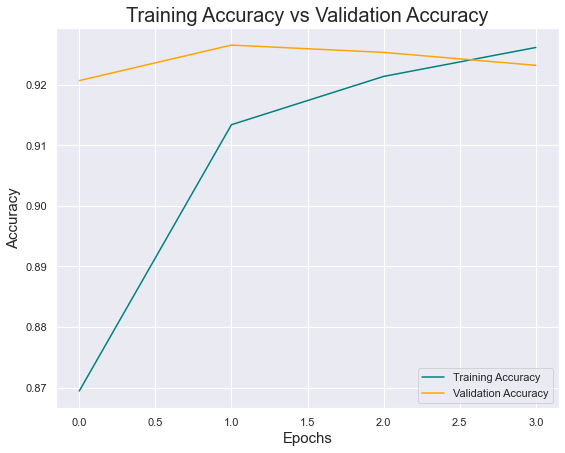

In [123]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.show()

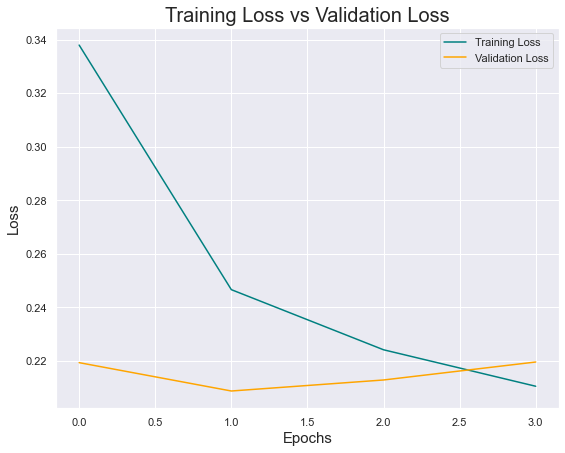

In [124]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.show()

In [125]:
y_p = model.predict(X_test)

1426/1426 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step


In [126]:
y_pred = np.where(y_p > 0.5, 1, 0)

In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     22802
           1       0.92      0.93      0.93     22803

    accuracy                           0.93     45605
   macro avg       0.93      0.93      0.93     45605
weighted avg       0.93      0.93      0.93     45605



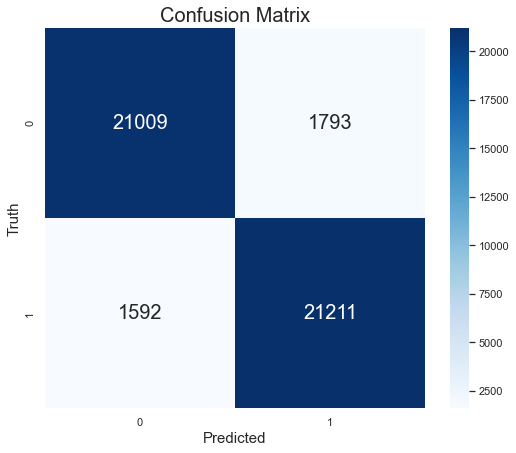

In [128]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, cbar = True, annot_kws = {'size' : 20}, fmt = 'd',
           cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 20)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Truth', fontsize = 15)
plt.show()